# Part 1 - EDA

In [1]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('darkgrid')


C:\Users\skrzym\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
times = pd.read_json('logins.json').set_index('login_time')
times['n'] = 1

In [3]:
def _sum(x):
    if len(x) == 0: return 0
    else: return sum(x)


In [4]:
fifteen = times.resample('15T').apply(_sum)

Below is a view of all the data based on the 15 minute time interval requested. There are definite cycles which I will investigate next.

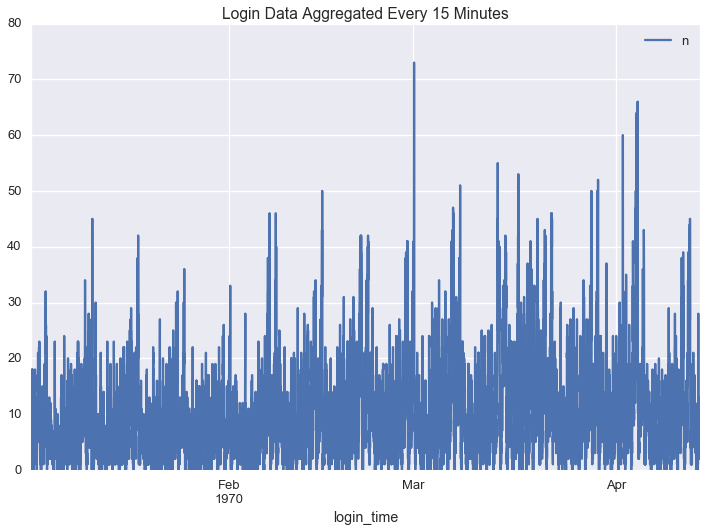

In [5]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
fifteen.plot(ax=ax)
plt.title('Login Data Aggregated Every 15 Minutes')
plt.show()

**Straight away I see an error with the data, or at least an oversight for gathering data for a full analysis, the timestamp has a year value of 1970 which seems quite improbable to be correct. **

***

As seen below, daily cycles in demand fluctuate between 500 and a peak of over 1750 in April.

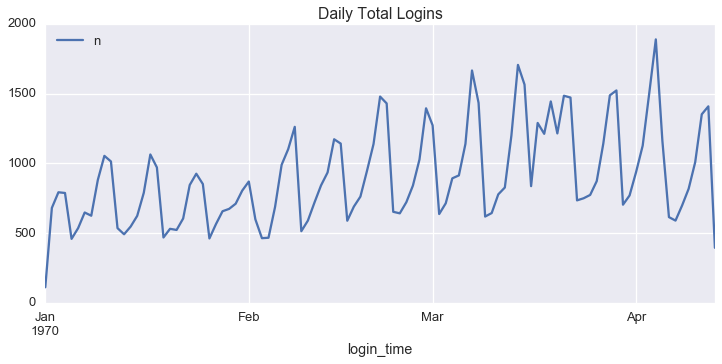

In [6]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
times.resample('1D').sum().plot(ax=ax)
plt.title('Daily Total Logins')
plt.show()

Below we can see the logins by hour for the month of March. We can see the demands spike for 2 days after every 5 days. Looks like the weekend but without proper dates we will have to confirm this suspicion a different way.

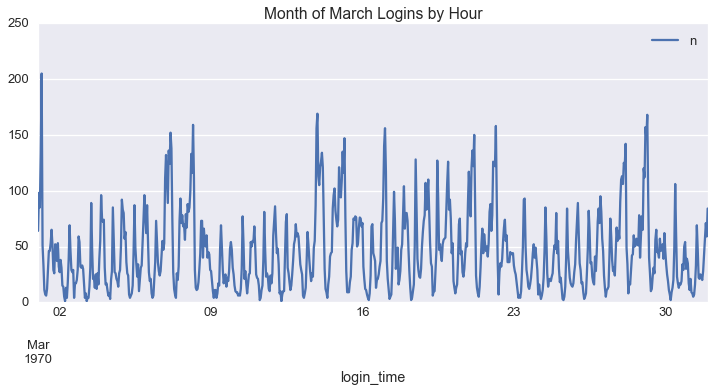

In [7]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
times['1970-03-01':'1970-03-031'].resample('60T').sum().plot(ax=ax)
plt.title("Month of March Logins by Hour")
plt.show()

This is the same time period except grouped by ever 6 hours to more clearly show the weekend spikes in user activity.

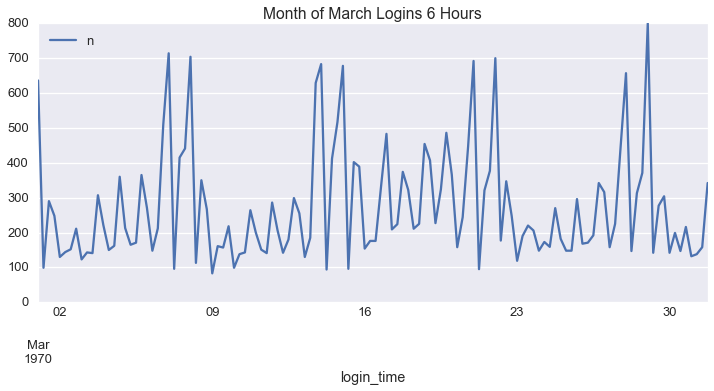

In [8]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
times['1970-03-01':'1970-03-031'].resample('6H').sum().plot(ax=ax)
plt.title("Month of March Logins 6 Hours")
plt.show()

To try and get a better view on this pattern we can pivot our data to look at logins by day of the week and by hour of the day. Turning this data wrangling into a visualization provides some better insight into how weekday logins differ by hour from weekend logins.

In [9]:
detailed_times = times.copy()

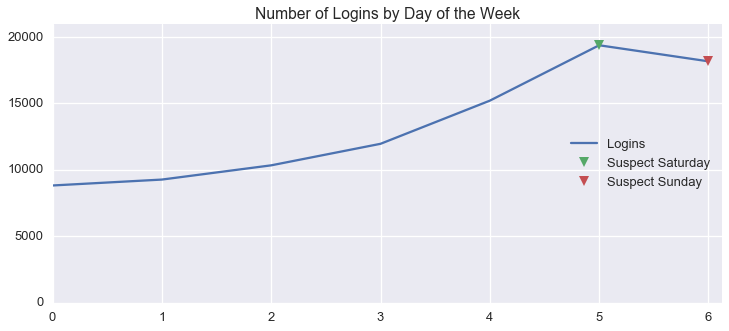

In [10]:
detailed_times['dayofweek'] = detailed_times.index.dayofweek

logins_by_dow = detailed_times.groupby('dayofweek').sum()['n']
suspect_saturday = logins_by_dow[5]
suspect_sunday = logins_by_dow[6]

fig,ax = plt.subplots(1,1,figsize=(12,5))
plt.plot(logins_by_dow,label='Logins')
plt.ylim(0,21000)
plt.xlim(0,6.125)
plt.title('Number of Logins by Day of the Week')
plt.plot(5,suspect_saturday,linestyle='none',marker='v',label='Suspect Saturday')
plt.plot(6,suspect_sunday,linestyle='none',marker='v', label='Suspect Sunday')
plt.legend(loc='center right')
plt.show()

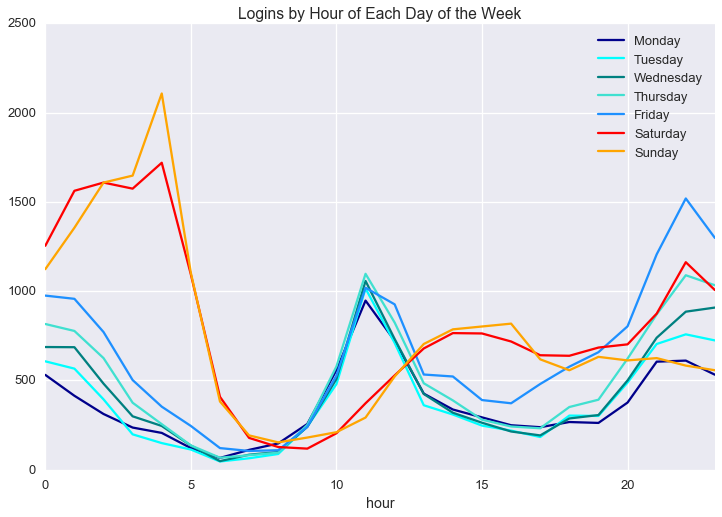

In [11]:
detailed_times['hour'] = detailed_times.index.hour
day_by_hour = detailed_times.pivot_table(index='hour',columns='dayofweek',values='n',aggfunc='sum')
plot_details = {0:('darkblue','Monday'),
                1:('cyan','Tuesday'),
                2:('teal','Wednesday'),
                3:('turquoise','Thursday'),
                4:('dodgerblue','Friday'),
                5:('red','Saturday'),
                6:('orange','Sunday')}

fig,ax = plt.subplots(1,1,figsize=(12,8))

for day in range(7):
    c = plot_details[day][0]
    l = plot_details[day][1]
    day_by_hour.loc[:,day].plot(c=c, label=l,ax=ax)
    plt.legend()
plt.title('Logins by Hour of Each Day of the Week')
plt.show()

Below is the pivot table that generated the visualization above and this data can be exported as a csv or excel file as well if needed.

In [12]:
day_by_hour

dayofweek,0,1,2,3,4,5,6
hour,,,,,,,
0,531,607,687,816,975,1254,1123
1,414,566,686,777,957,1562,1355
2,312,394,482,625,771,1608,1608
3,236,198,299,375,502,1574,1647
4,206,149,245,255,353,1719,2107
5,121,113,135,136,245,1093,1102
6,66,46,48,67,121,408,382
7,111,64,84,81,105,178,192
8,147,88,99,95,109,127,153


# Part 2 - Experiment and Metrics Design

Since Gotham and Metropolis are most active at different times during the day except on weekends, I would say a measure of success for this toll bridge subsidy should be to see a significant increase in the number of people serviced by partners of one city during the busy time for its opposite. We want to help manage demand during known peak times, and if this plan can be deemed a success, we should see a significant change in drivers patterns during these times. If the managers are not looking to deal with demand issues and just want to encourage flexibility in its partners, then a simpler metric could be adopted where success would be defined as having drivers service the same amount of customers from both cities. In other words, all drivers would still service the same number of people, only the distribution between the cities should drastically change as to almost make the city data indistinguishable from one another.

To test this measure and the experiment overall, I would state that we have two groups. Metropolis and Gotham partners before the change and after the change. For each group I would measure the percentage of their total rides sourced from the oposite's city per week. We would have our baseline computed to what a few months worth of data (if available) looked like for this test statistic prior to the change. Next we would collect new data and compare each new week and eventually month(s) with this baseline using a permutation test to measure the significance in any difference between the ratios of the two groups. As stated before the goal would be to reach a state where the partners are servicing just as many customers from one city as the other so our weekly testing would not only be looking for significant change but be able to tell us how close to that goal we are getting.

# Part 3 - Predictive Modeling


In [13]:
with open('ultimate_data_challenge.json') as file:
    rows=json.loads(file.read()) 
udc = pd.DataFrame.from_records(rows)

In [14]:
udc.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [15]:
udc.last_trip_date = pd.to_datetime(udc.last_trip_date)
udc.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

## Active Users

We will define any user who's** `last_trip_date` **falls in the month of June or July as an **'active'** user

In [16]:
udc['active'] = udc.last_trip_date.apply(lambda x: x.month in [6,7])
udc.active = udc.active.astype(int)

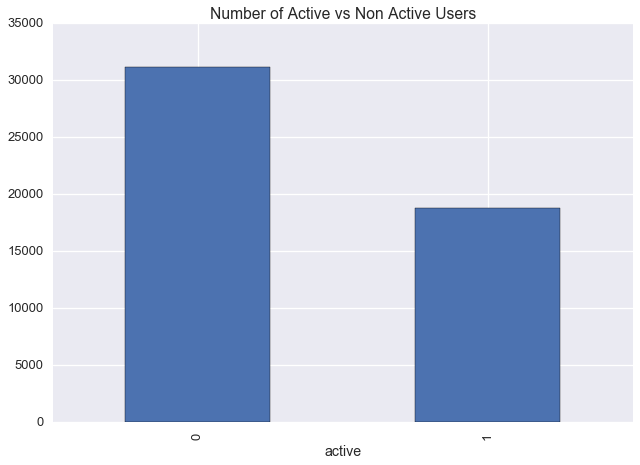

In [17]:
udc.groupby('active').count()['city'].plot(kind='bar')
plt.title('Number of Active vs Non Active Users')
plt.show()

***
## Dealing with Missing Data

In [18]:
udc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null int32
dtypes: bool(1), datetime64[ns](1), float64(6), int32(1), int64(1), object(3)
memory usage: 4.4+ MB


Looking at the number of non-null data available per factor it looks like the biggest source of missing data is in the **`avg_rating_of_driver`** factor. Eliminating this factor without investigation is not advised as we are trying to determine retention and a user's average rating of their drivers is intuitively a strong candidate for indicating a retained or lost customer. The simple method is to just eliminate any rows that have a null value. However that will eliminate almost 20% of our available data.  

I propose that all rows with no ***`by_driver`*** rating and ***`phone`*** value be dropped (1.2% data loss) and for any row without an ***`of_driver`*** rating we infer that the rating be calculated as follows: ***`by_driver[i]` - mean(`by_driver` - `of_driver`)***

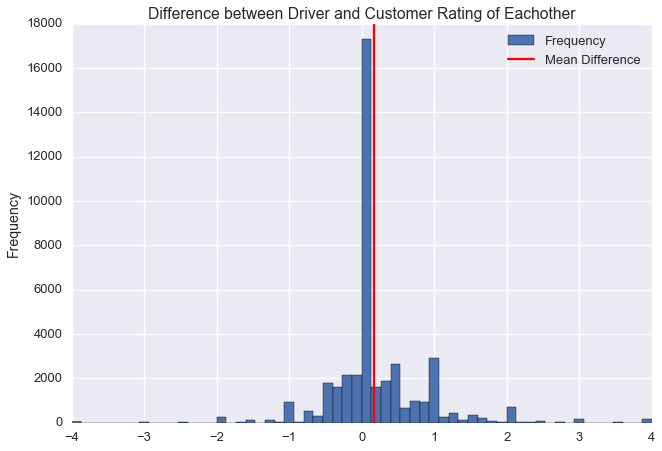

In [19]:
udc_copy = udc.copy()
diff = udc_copy.avg_rating_by_driver-udc_copy.avg_rating_of_driver
mean_diff = np.mean(diff)
diff.plot(kind='hist', bins=60, label='Frequency')
plt.vlines(np.mean(diff),0,18000,color='red',label='Mean Difference')
plt.legend()
plt.title('Difference between Driver and Customer Rating of Eachother')
plt.show()

In [20]:
def correct_ratings(row):
    if pd.isnull(row.avg_rating_of_driver):
        row.avg_rating_of_driver = row.avg_rating_by_driver - mean_diff
    return row

In [21]:
udc_clean = udc[~udc.avg_rating_by_driver.isnull() & ~udc.phone.isnull()]
udc_clean = udc_clean.apply(correct_ratings,axis=1)

In [22]:
udc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49406 non-null float64
avg_rating_by_driver      49406 non-null float64
avg_rating_of_driver      49406 non-null float64
avg_surge                 49406 non-null float64
city                      49406 non-null object
last_trip_date            49406 non-null datetime64[ns]
phone                     49406 non-null object
signup_date               49406 non-null object
surge_pct                 49406 non-null float64
trips_in_first_30_days    49406 non-null int64
ultimate_black_user       49406 non-null bool
weekday_pct               49406 non-null float64
active                    49406 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(6), int64(2), object(3)
memory usage: 4.9+ MB


In [23]:
remaining_user_percentage = (49406.0/50000.0) * 100
remaining_user_percentage

98.812

**98.8% of users remain after dealing with missing data**

***


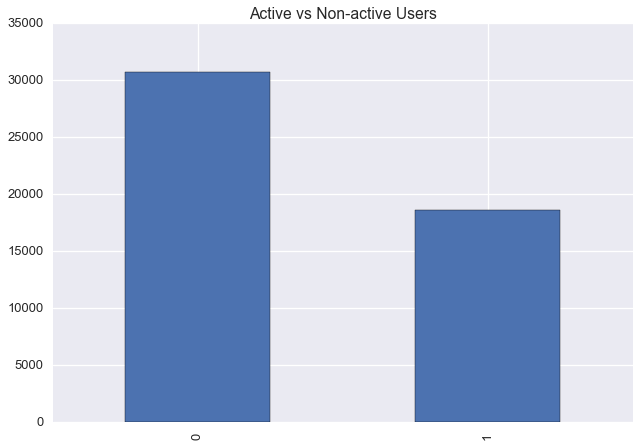

In [24]:
udc_clean.active.value_counts().plot(kind='bar')
plt.title('Active vs Non-active Users')
plt.show()

***
## Dealing with Categorical Variables
There are 4 main categorical values that should be delt with before building a predictive model.  
1) phone  
2) signup_date  
3) city  
4) last_trip_date  

**`last_trip_date`** will be removed for model building since we used it to determine if a user was active or not. Keeping this data will heavily bias our model and our goal is to look for other factors that impact a user's active status.

**`phone`** only contains two categories. iPhone or Android. We can convert this into two dummy variables or for simplicity just a boolean factor **`is_iPhone`**. True indicates an iPhone user while False indicates an Android user.

**`city`** has three categories and will be turned into 3 dummy variables using pandas built in **`get_dummies`** method.

**`signup_date`** will be transformed into two new factors - **`signup_dow`** and **`signup_day`** which respectively indicate the day of the week and the day of the month.

In [25]:
# Eliminate last_trip_date factor
udc_model = udc_clean.drop('last_trip_date', axis=1)

# Convert signup_date to datetime and extract day of week and month characteristics
udc_model.signup_date = pd.to_datetime(udc_model.signup_date)
udc_model['signup_dow'] = udc_model.signup_date.dt.dayofweek
udc_model['signup_day'] = udc_model.signup_date.dt.day

# Eliminate signup_date factor
udc_model =  udc_model.drop('signup_date', axis=1)

# Convert phone categorical to 'is_iPhone' boolean and drop original factor
udc_model['is_iPhone'] = udc_model.phone == 'iPhone'
udc_model =  udc_model.drop('phone', axis=1)

# Convert city categorical to 3 dummy factors for each city via 'one-hot' encoding
udc_model = pd.get_dummies(udc_model)

# Review updated dataframe
udc_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 15 columns):
avg_dist                  49406 non-null float64
avg_rating_by_driver      49406 non-null float64
avg_rating_of_driver      49406 non-null float64
avg_surge                 49406 non-null float64
surge_pct                 49406 non-null float64
trips_in_first_30_days    49406 non-null int64
ultimate_black_user       49406 non-null bool
weekday_pct               49406 non-null float64
active                    49406 non-null int64
signup_dow                49406 non-null int64
signup_day                49406 non-null int64
is_iPhone                 49406 non-null bool
city_Astapor              49406 non-null uint8
city_King's Landing       49406 non-null uint8
city_Winterfell           49406 non-null uint8
dtypes: bool(2), float64(6), int64(4), uint8(3)
memory usage: 4.4 MB


***
## Modeling

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
rf = RandomForestClassifier(random_state=42)
X = udc_model.drop('active', axis=1)
y = udc_model[['active']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rf.fit(X_train, y_train.active.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [27]:
y_train.active.values

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [70]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[50,150,300],
             'min_samples_leaf': [25,50,100,150,200]}
clf = GridSearchCV(rf, param_grid, cv=10, verbose=10, n_jobs=5)
clf.fit(X_train, y_train.active.values)

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   19.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   40.1s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   56.6s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed:  3.6min finished


Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'min_samples_leaf': [25, 50, 100, 150, 200], 'n_estimators': [50, 150, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [71]:
clf.best_params_

{'min_samples_leaf': 25, 'n_estimators': 300}

Since our best parameters from our grid search both landed at the extremes of their respective lists I want to re-run the grid search expanding the lists to see if the parameters can be improved further.

In [77]:
param_grid = {'n_estimators':[300,350,400,450,500],
             'min_samples_leaf': [1,5,10,15,20,25]}
clf = GridSearchCV(rf, param_grid, cv=10, verbose=10, n_jobs=4)
clf.fit(X_train, y_train.active.values)

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   54.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 11.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.5min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 13.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 15.1min
[Parallel(n_jobs=4)]: Do

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'min_samples_leaf': [1, 5, 10, 15, 20, 25], 'n_estimators': [300, 350, 400, 450, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [78]:
clf.best_params_

{'min_samples_leaf': 10, 'n_estimators': 450}

In [79]:
clf.best_score_

0.78206754878859286

Best Parameters: {'min_samples_leaf': 10, 'n_estimators': 450}

Best Score:
0.78206754878859286

In [28]:
forest = RandomForestClassifier(n_estimators=450, min_samples_leaf=10, random_state=42)

In [29]:
forest.fit(X_train, y_train.active.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=450, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

Feature ranking:
1. avg_rating_by_driver		 (0.16102366387839942)
2. weekday_pct		 (0.122247737451557)
3. surge_pct		 (0.11735281540808158)
4. city_King's Landing		 (0.10123086086217256)
5. avg_surge		 (0.0779142021364536)
6. avg_dist		 (0.07274881048254182)
7. is_iPhone		 (0.0652489478630729)
8. trips_in_first_30_days		 (0.06178465768858426)
9. ultimate_black_user		 (0.05621595941862346)
10. signup_day		 (0.044040818843031286)
11. avg_rating_of_driver		 (0.04212725673507343)
12. city_Astapor		 (0.03197566832478108)
13. signup_dow		 (0.02598381667925178)
14. city_Winterfell		 (0.020104784228375697)


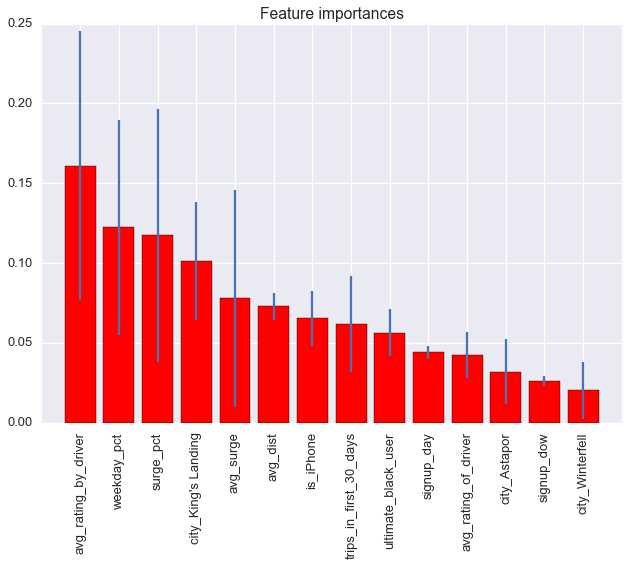

In [30]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = X_train.columns.tolist()
ordered_names = [names[index] for index in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}. {}\t\t ({})".format(f + 1, names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), ordered_names, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

***

Our model indicates that the important features that determine an active user are as follows, listed in their order of importance:  
1) Average rating by the driver  
2) Number of weekday rides  
3) Surge percentage value  
4) Being from King's Landing  
5) Average surge price  
6) Average ride distance  
7) iPhone usage  
8) # of trips last 30 days  
9) Ultimate black user  
10) Day of signing up  
11) Average rating of the driver  
12) Being from Astapor  
13) Day of the week they signed up  
14) Being from Winterfell  